## Individual predictions for STEMI patients

In [1]:
#!pip install shap --upgrade
import shap
shap.initjs()
import os
import pickle
import pandas as pd
from pandas import read_csv
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt

Fuentes:
https://github.com/slundberg/shap/issues/977
https://github.com/slundberg/shap/issues/1252
https://github.com/slundberg/shap/issues/963

In [2]:
def read_data(raw_clinical_note):
    """ Read clinical data """
    data = pd.read_csv(raw_clinical_note, header=0,na_filter=True)
    columns = ['subject_id','hadm_id','icustay_id','Unnamed: 0'] ##'los','endotrachflag','insertion_of_endotracheal_tube','vent'
    x = data.drop(columns,axis = 1)
    return x

def read_ydata(data):
    """ Read ydata """
    data=pd.read_csv(data, header=0,na_filter=True)
    y=pd.DataFrame(data["icustay_expire_flag"],columns=["icustay_expire_flag"])
    return y

def data_scaler(data,path_model):
    """inverse_transform scaler"""
    print("path_scaler:",path_model)
    scaler = pickle.load(open(path_model+"scaler_stemi",'rb')) #load scaler
    data = scaler.inverse_transform(data)
    return data

def generating_metrics(model_loaded, x, y,path_model):
    from sklearn.metrics import classification_report
    """Function to generate metrics: auc_score, sensitivity, specificity, f1, accuracy"""
    y_predicted = model_loaded.predict_proba(x)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_predicted[:,1])
    auc_score= auc(false_positive_rate, true_positive_rate)

    y_pred = model_loaded.predict(x)
    acc = accuracy_score(y,y_pred)
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    f1 = f1_score(y, y_pred)

    y_predicted=pd.DataFrame(y_predicted[:,1],columns=["model_predict_proba"])
    y_predicted.to_csv(path_model+"model_y_predicted_combined.csv")
    return auc_score, sensitivity, specificity, f1, acc, false_positive_rate, true_positive_rate

def opening_model(path_model):
    print("============= Opening model ================")
    file_in = os.path.join(path_model+"modelXGB")
    print("Opening model: ",file_in)
    with open(file_in, 'rb') as final_model:
        model = pickle.load(final_model)
    return model

def saving_model(model_ehr,path_model):
    print("============= Saving model ================")
    file_out = os.path.join(path_model+"modelXGB")
    with open(file_out, 'wb') as modelfile:
        pickle.dump(model_ehr,modelfile)
        
def mortality_model(xtrain,xtest,ytrain,ytest, 
                    path_model, model_name):
    print("===================== Loading data ===================================")
    xtrain=read_data(xtrain)
    xtest=read_data(xtest)
    ytrain=read_ydata(ytrain)    
    ytest=read_ydata(ytest)
        
    labels = pd.concat([ytrain,ytest])
    join_sets= pd.concat([xtrain,xtest])
    feature_list=join_sets.columns
    print("join_sets:",join_sets.shape)
    print("labels:",labels.shape)

    "Rescaling data"
    xtrain_scaled=data_scaler(xtrain,path_model)
    xtest_scaled=data_scaler(xtest,path_model)
    join_sets_scaled=data_scaler(join_sets,path_model)
    
    print("===================== Loading model ===================================")
    model_loaded = opening_model(path_model)
    
    auc_test, sens_test, spec_test, f1_test, acc_test,fpr, tpr = generating_metrics(model_loaded, xtest_scaled, 
                                                                                    ytest,path_model)
    print("auc_test: {}, sens_test {}, spec_test: {}, f1_test {}, acc_test {}".format(auc_test, sens_test, 
                                                                                      spec_test, f1_test, 
                                                                                      acc_test))
    
    return model_loaded, join_sets,join_sets_scaled,feature_list,labels
    
def summary_plot(xgb_model, data,feature_list):
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(data)
    shap.summary_plot(shap_values,data,
                    feature_names=feature_list,
                    plot_type="dot",
                    max_display=20)

def summary_plot_bar(xgb_model, data,feature_list):
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(data)
    shap.summary_plot(shap_values,data,
                    feature_names=feature_list,
                    plot_type="bar",
                    max_display=20)
    
def shap_interactions_sex(xgb_model,data,path_model):
    data_scaled=data_scaler(data,path_model)   
    feature_list=data.columns.tolist()

    shap_interaction_values = shap.TreeExplainer(xgb_model).shap_interaction_values(data_scaled)
    
    shap.dependence_plot((feature_list.index('Age'), 
                          feature_list.index('Sex')),
                          shap_interaction_values, data)        
    plt.show()
    
def searching_patients(explainer,shap_values,data,positives):
    "Function to visualize shap force"
    print(type(positives))
    for i in range(len(positives)):
        shap.force_plot(explainer.expected_value, shap_values[positives[i],:], 
                    data.iloc[positives[i],:],show=False,figsize=(40,3),matplotlib=True)
        plt.savefig("img_"+str(positives[i])+".png",dpi=150, bbox_inches='tight')
        plt.close()
        
def plot_specific_patient(explainer,shap_values,index,data,name):
    shap.force_plot(explainer.expected_value, shap_values[index,:], 
                   data.iloc[index,:],show=False,figsize=(35,3),matplotlib=True)
    plt.savefig(str(name)+"_"+str(index)+".pdf",dpi=200, bbox_inches='tight')
    plt.close()    

In [3]:
xtrain = '../data/stemi/xtrain_combined.csv'
xtest = '../data/stemi/xtest_combined.csv'
ytrain = '../data/stemi/ytrain_combined.csv'
ytest = '../data/stemi/ytest_combined.csv'
path_model = '../models/stemi/'
model_name = 'XGB'

model_loaded, join_sets,join_sets_scaled,feature_list,labels= mortality_model(xtrain,xtest,ytrain,ytest,path_model, model_name)

===================== Loading data ===================================
join_sets: (1299, 266)
labels: (1299, 1)
path_scaler: ../models/stemi/
path_scaler: ../models/stemi/
path_scaler: ../models/stemi/
===================== Loading model ===================================
============= Opening model ================
Opening model:  ../models/stemi/modelXGB
auc_test: 0.9399661099007504, sens_test 0.9411764705882353, spec_test: 0.8724279835390947, f1_test 0.5, acc_test 0.8769230769230769


## Individual predictions (Women with STEMI)
Source: https://github.com/slundberg/shap/issues/963

In [4]:
join_sets["label"] = labels #added the label to join_sets
women_label = join_sets[(join_sets.Sex==0)].round(2) #selection "Women"
women = women_label.drop(['label'],axis=1)

women_scaled=data_scaler(women,path_model).round(2)
women_scaled = women_scaled.round(2)

path_scaler: ../models/stemi/


In [5]:
positives_women = np.where(women_label.label==1)
print("Positives index (death):",positives_women)

Positives index (death): (array([  2,  19,  21,  33,  54,  55,  94,  97, 102, 110, 115, 116, 120,
       125, 128, 144, 167, 175, 182, 185, 187, 194, 195, 218, 225, 230,
       266, 271, 282, 285, 291, 326, 358, 362, 383, 392, 395, 405, 408,
       413, 437, 441]),)


In [6]:
explainerModel_prob = shap.TreeExplainer(model_loaded,
                                         data = shap.sample(women_scaled, 50),
                                         model_output='probability')
shap_values_model_prob  = explainerModel_prob.shap_values(women_scaled)

Expired patient


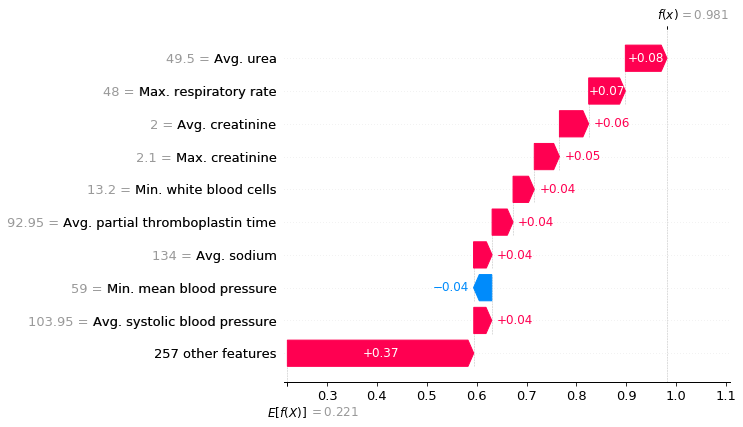

In [7]:
print("Expired patient")
id=125
shap.plots._waterfall.waterfall_legacy(explainerModel_prob.expected_value, 
                                       shap_values_model_prob[id,:],
                                       women.iloc[id,:],show=False)
plt.savefig("stemi_women_expired_"+str(id)+".pdf",dpi=200, bbox_inches='tight')
plt.close() 

In [8]:
index_patient=125
data_patient = women_scaled[index_patient].reshape(-1,len(women.columns))

print("Age:", women_label.Age.iloc[index_patient])
print("y_true::", women_label.label.iloc[index_patient])

print("Prediction ::", model_loaded.predict(data_patient))
print("Predict_proba ::",model_loaded.predict_proba(data_patient))

Age: 81.4
y_true:: 1
Prediction :: [1]
Predict_proba :: [[0.01869571 0.9813043 ]]


In [9]:
print("Survived patient")
id=426
shap.plots._waterfall.waterfall_legacy(explainerModel_prob.expected_value, 
                                       shap_values_model_prob[id,:],
                                       women.iloc[id,:],show=False)
plt.savefig("stemi_women_survived_"+str(id)+".pdf",dpi=200, bbox_inches='tight')
plt.close() 

Survived patient


In [10]:
index_patient=426
data_patient = women_scaled[index_patient].reshape(-1,len(women.columns))

print("Age:", women_label.Age.iloc[index_patient])
print("y_true::", women_label.label.iloc[index_patient])

print("Prediction ::", model_loaded.predict(data_patient))
print("Predict_proba ::",model_loaded.predict_proba(data_patient))

Age: 65.98
y_true:: 0
Prediction :: [0]
Predict_proba :: [[0.9989626  0.00103742]]


## Individual predictions (Men with STEMI)

In [11]:
#Individual predictions
men_label = join_sets[(join_sets.Sex==1)].round(2) #selection "Men"
men = men_label.drop(['label'],axis=1)

men_scaled=data_scaler(men,path_model).round(2)
men_scaled = men_scaled.round(2)

positives_men = np.where(men_label.label==1)
print("Positives index (death):",positives_men)
positives_men = np.array(positives_men).reshape(46,-1)

path_scaler: ../models/stemi/
Positives index (death): (array([ 20,  27,  33,  83,  91, 143, 150, 152, 188, 212, 229, 242, 246,
       258, 259, 279, 369, 370, 397, 429, 438, 449, 461, 462, 501, 527,
       535, 540, 542, 543, 579, 594, 595, 646, 647, 653, 691, 692, 695,
       697, 716, 764, 820, 822, 826, 835]),)


In [12]:
explainerModel_prob = shap.TreeExplainer(model_loaded,
                                         data = shap.sample(men_scaled, 100),
                                         model_output='probability')
shap_values_model_prob  = explainerModel_prob.shap_values(men_scaled)

Expired patient


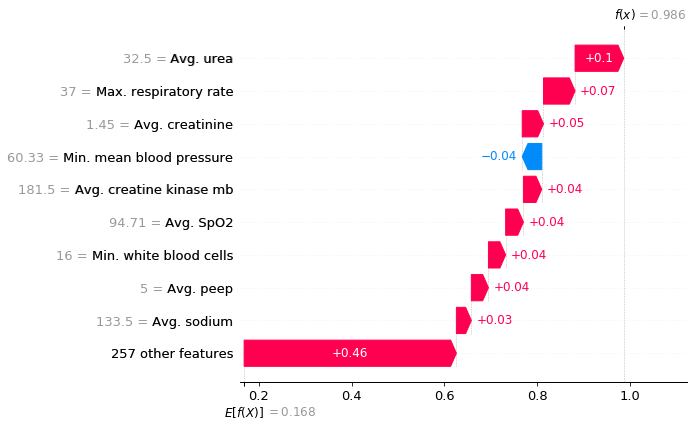

In [13]:
print("Expired patient")
id=540
shap.plots._waterfall.waterfall_legacy(explainerModel_prob.expected_value, 
                                       shap_values_model_prob[id,:],
                                       men.iloc[id,:],
                                       show=False)
plt.savefig("stemi_men_expired_"+str(id)+".pdf",dpi=200, bbox_inches='tight')
plt.close() 

In [14]:
np_array = shap_values_model_prob[540,:].reshape(-1,266)
prueba = pd.DataFrame(np_array,columns=men.columns)

sum_columns = prueba.sum(axis=1)
print("sumando todas las columnas: ", prueba.sum(axis=1))

base_value=0.168
print("resultado final: ", sum_columns+base_value)

sumando todas las columnas:  0    0.817618
dtype: float64
resultado final:  0    0.985618
dtype: float64


In [15]:
index_patient=540
data_patient = men_scaled[index_patient].reshape(-1,len(men.columns))

print("Age:", men_label.Age.iloc[index_patient])
print("y_true::", men_label.label.iloc[index_patient])

print("Prediction ::", model_loaded.predict(data_patient))
print("Predict_proba ::",model_loaded.predict_proba(data_patient))

Age: 75.99
y_true:: 1
Prediction :: [1]
Predict_proba :: [[0.01389474 0.98610526]]


Survived patient


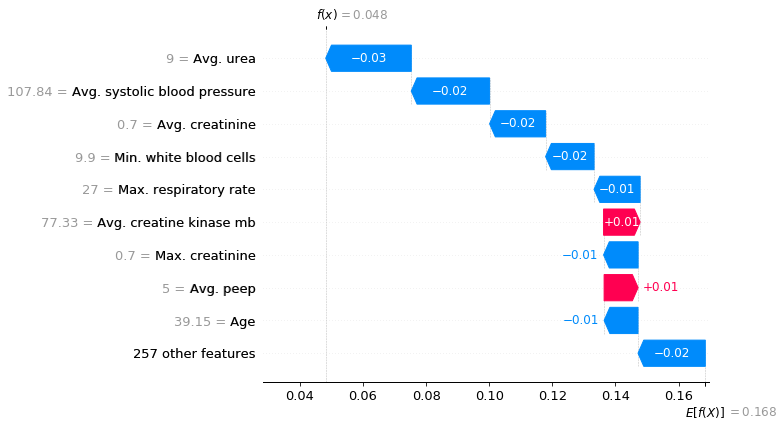

In [16]:
print("Survived patient")
id=6
shap.plots._waterfall.waterfall_legacy(explainerModel_prob.expected_value, 
                                       shap_values_model_prob[id,:],
                                       men.iloc[id,:],
                                       show=False)
plt.savefig("stemi_men_survived_"+str(id)+".pdf",dpi=200, bbox_inches='tight')
plt.close() 

In [17]:
index_patient=6
data_patient = men_scaled[index_patient].reshape(-1,len(men.columns))

print("Age:", men_label.Age.iloc[index_patient])
print("y_true::", men_label.label.iloc[index_patient])

print("Prediction ::", model_loaded.predict(data_patient))
print("Predict_proba ::",model_loaded.predict_proba(data_patient))

Age: 39.15
y_true:: 0
Prediction :: [0]
Predict_proba :: [[0.9518231  0.04817688]]
